## Imports and settings

In [1]:
import src
import keras.backend as K

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from os import *
import numpy as np
import sys
import re
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')

In [3]:
#forces CPU usage
environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
environ["CUDA_VISIBLE_DEVICES"] = "0" #"" or "-1" for CPU, "0" for GPU
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8926466305088273110
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1508248780
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2611616496164262616
physical_device_desc: "device: 0, name: GeForce GT 740M, pci bus id: 0000:01:00.0, compute capability: 3.5"
]


In [4]:
train, xval, test = src.load_datasets("5min", past_frames=1)

Training data: (7500, 64, 64, 2)
Validation data: (1500, 64, 64, 2)
Test data: (1000, 64, 64, 2)


In [5]:
gan_train, gan_truth, gan_val, gan_val_truth, gan_test, gan_test_truth = src.split_datasets(
            train[:800], xval, test, past_frames=1, augment=True)

Data augmentation.
Shape of training data:  (6400, 64, 64, 1) 
Shape of training truth:  (6400, 64, 64, 1) 
Shape of validation data:  (1500, 64, 64, 1) 
Shape of validation truth:  (1500, 64, 64, 1) 
Shape of test data:  (1000, 64, 64, 1) 
Shape of test truth:  (1000, 64, 64, 1)


## U-net

In [6]:
model = src.unet()

In [10]:
#train the model
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate = 0.0001),loss=src.custom_loss("l1+gdl"), metrics=[src.relative_error_tensor]) 

***Using L1 + gradient difference loss.***
Tensor("metrics_2/relative_error_tensor/truediv:0", shape=(), dtype=float32)
Tensor("conv2d_10_target_2:0", shape=(?, ?, ?, ?), dtype=float32)


In [11]:
model.fit(gan_train,
          gan_truth,
          batch_size = 10,
          epochs=10,
          validation_data=(gan_val,gan_val_truth),
          shuffle = False)

Train on 6400 samples, validate on 1500 samples
Epoch 1/10
6400/6400 [==============================] - 104s 16ms/step - loss: 0.1781 - relative_error_tensor: 1.8846 - val_loss: 0.1542 - val_relative_error_tensor: 0.7076loss: 0.1795 - relative_e
Epoch 2/10
6400/6400 [==============================] - 120s 19ms/step - loss: 0.1365 - relative_error_tensor: 1.0329 - val_loss: 0.1452 - val_relative_error_tensor: 0.6616tive_error_tensor - E
Epoch 3/10
6400/6400 [==============================] - 117s 18ms/step - loss: 0.1284 - relative_error_tensor: 0.8912 - val_loss: 0.1416 - val_relative_error_tensor: 0.6424
Epoch 4/10
6400/6400 [==============================] - 116s 18ms/step - loss: 0.1235 - relative_error_tensor: 0.8199 - val_loss: 0.1378 - val_relative_error_tensor: 0.6214
Epoch 5/10
6400/6400 [==============================] - 128s 20ms/step - loss: 0.1203 - relative_error_tensor: 0.7755 - val_loss: 0.1338 - val_relative_error_tensor: 0.5968sor: 0.78 - ETA: 4s - loss: 0.1208 - relat

Text(0,0.5,'Loss')

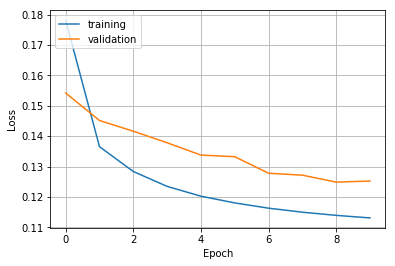

In [12]:
hist = model.history
hist.history.keys()
plt.plot(hist.history['loss'],)
plt.plot(hist.history['val_loss'])
plt.grid()
plt.legend(['training', 'validation'], loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.yscale("log")
#plt.savefig('training.png')

In [15]:
#test
predictions = model.predict(gan_test, batch_size=100)
truth       = gan_test_truth
truth.shape

(1000, 64, 64, 1)

In [16]:
args = src.arg_getter(truth, predictions)
args[-1]

C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:659: RuntimeWarning: divide by zero encountered in true_divide
  images[i] = np.divide(num, den)
C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:659: RuntimeWarning: invalid value encountered in true_divide
  images[i] = np.divide(num, den)


608

C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:659: RuntimeWarning: divide by zero encountered in true_divide
  images[i] = np.divide(num, den)
C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:659: RuntimeWarning: invalid value encountered in true_divide
  images[i] = np.divide(num, den)


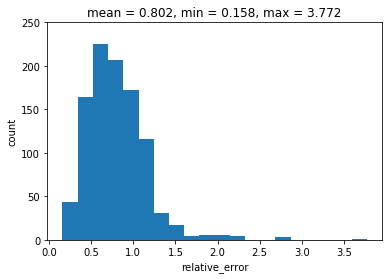

In [17]:
error_images, error_vals, error_means = src.error_distribution(truth,predictions,metric="relative_error")

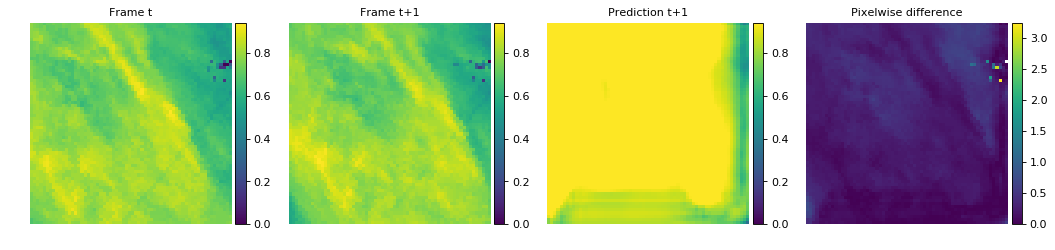

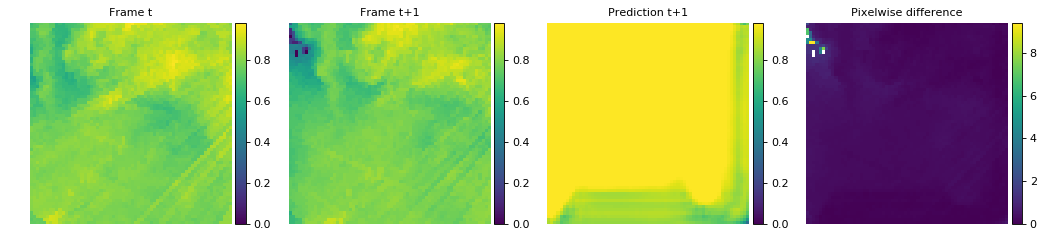

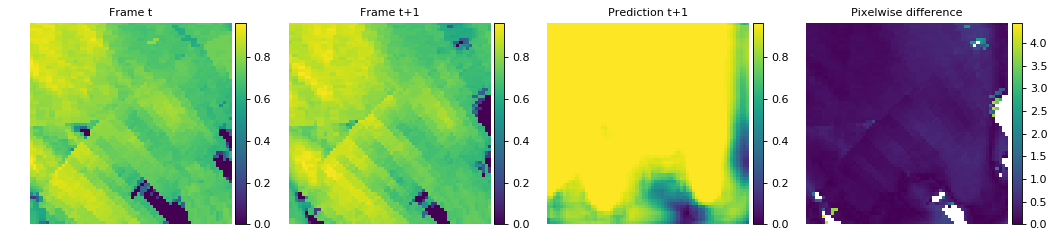

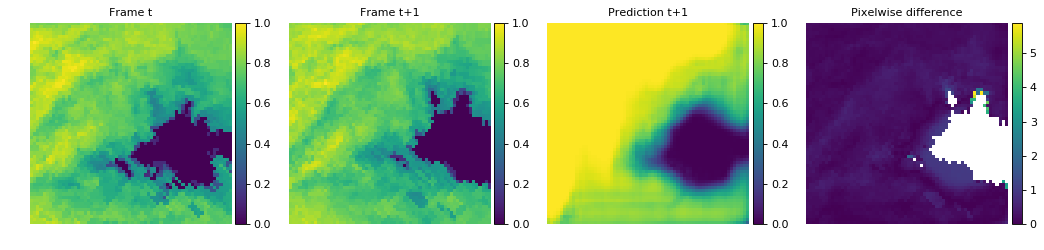

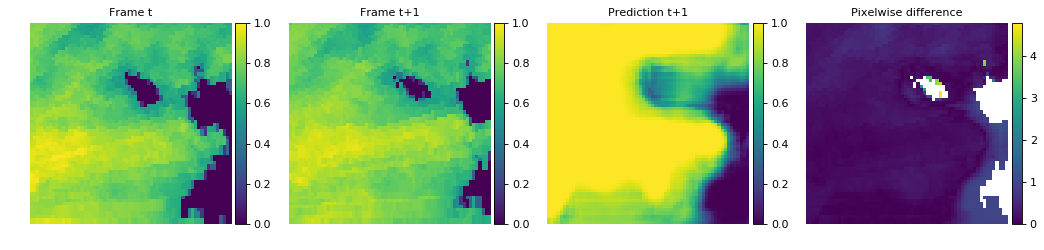

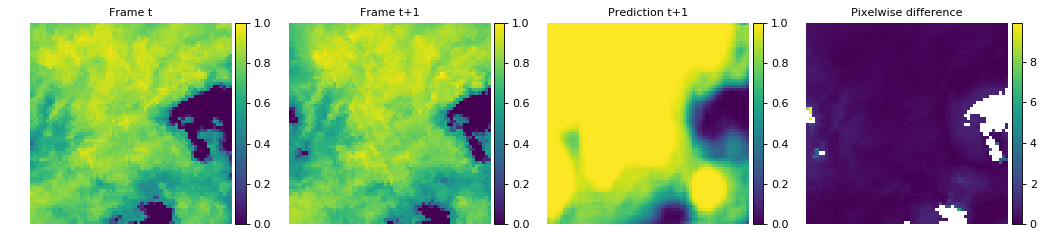

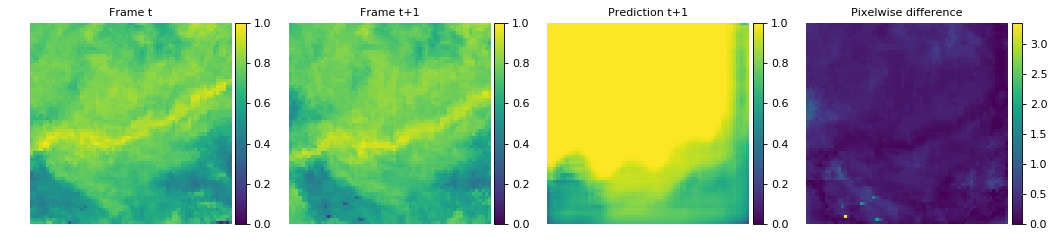

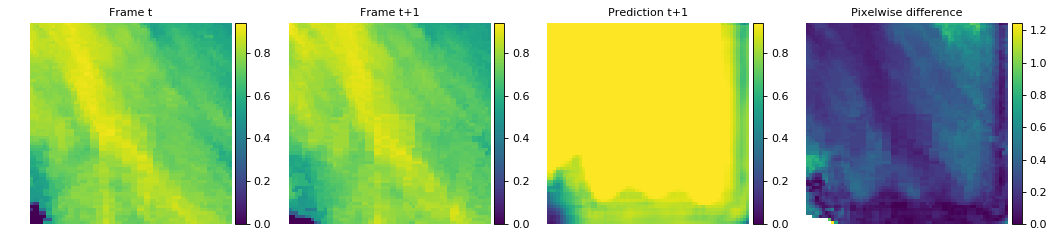

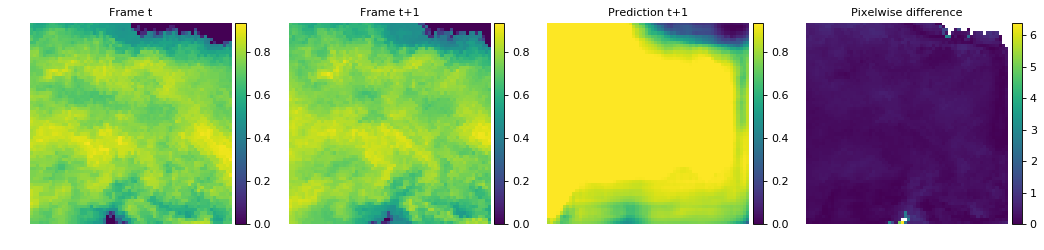

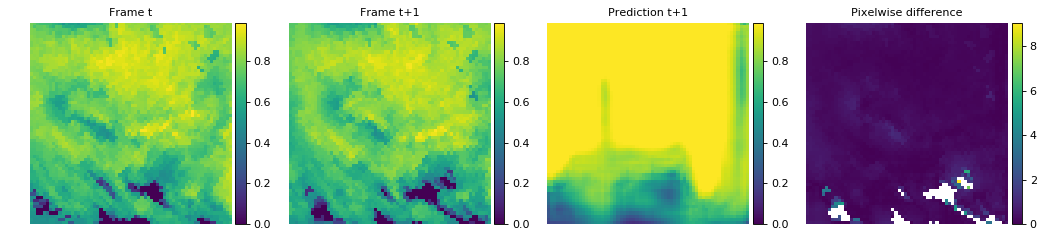

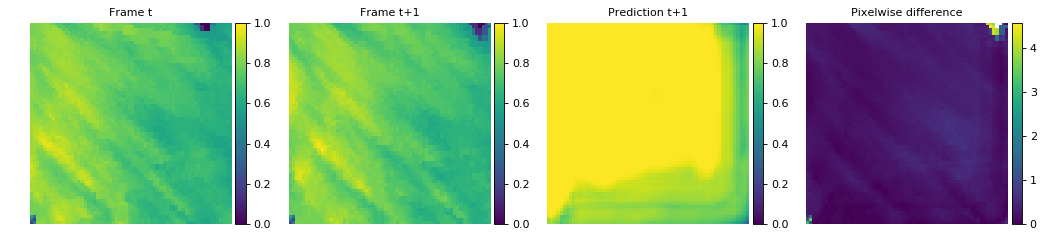

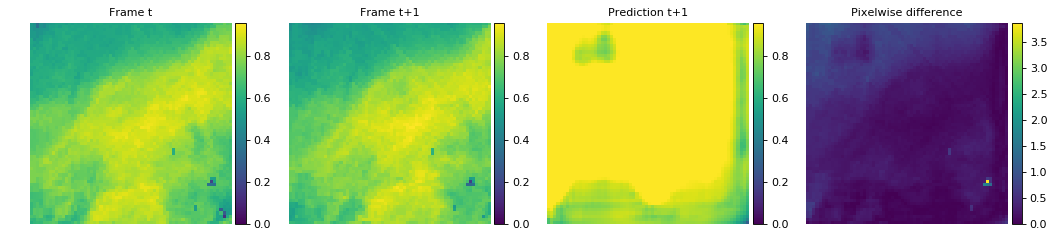

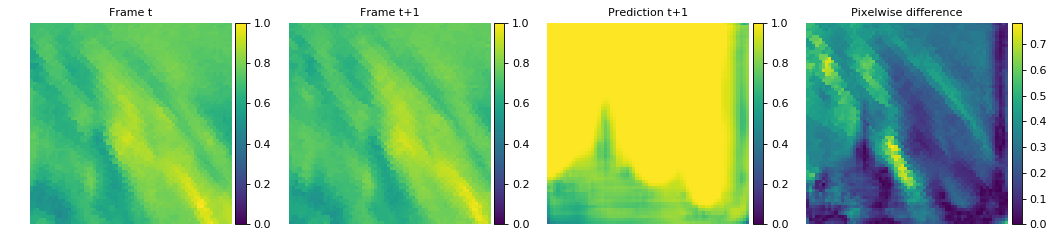

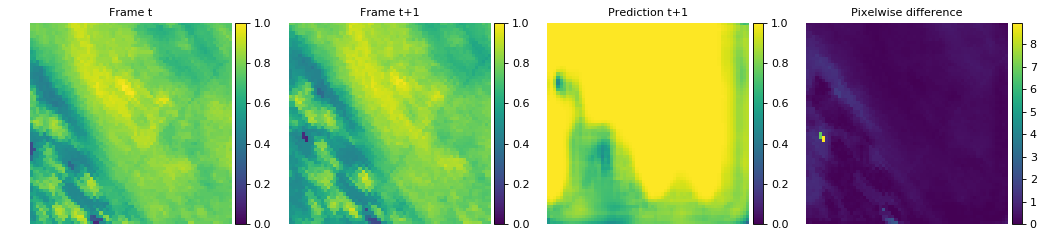

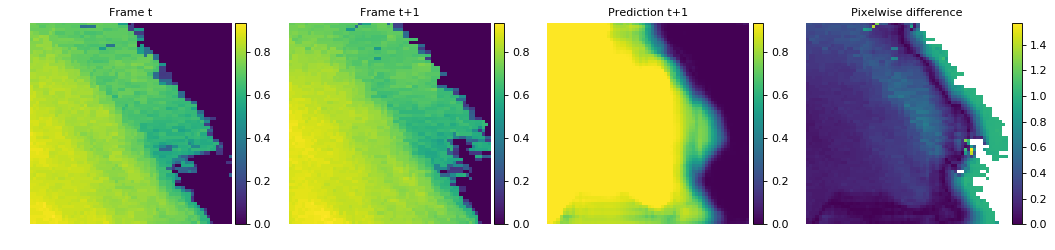

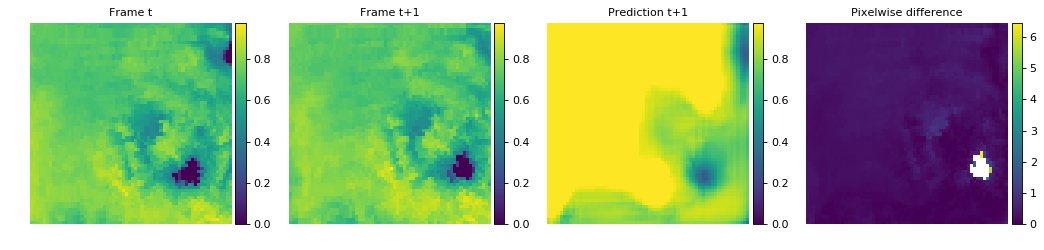

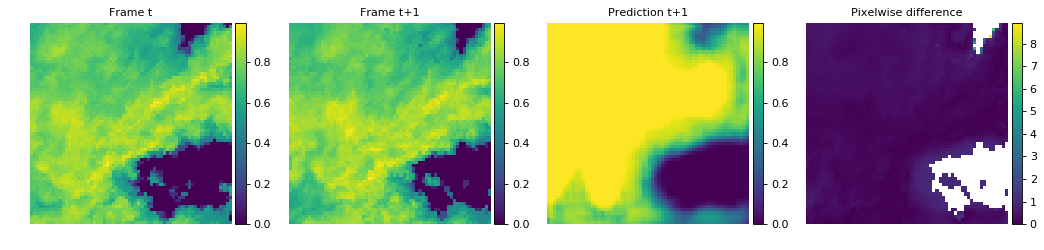

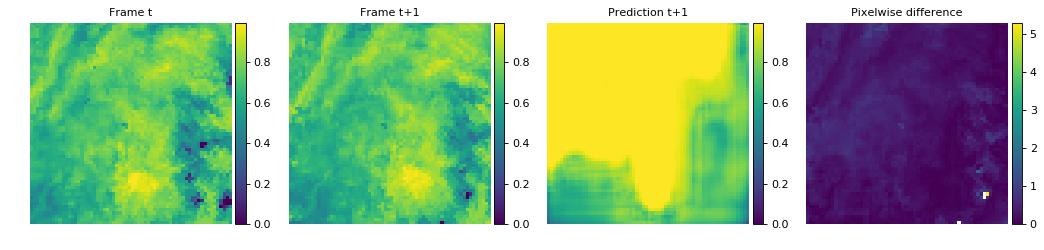

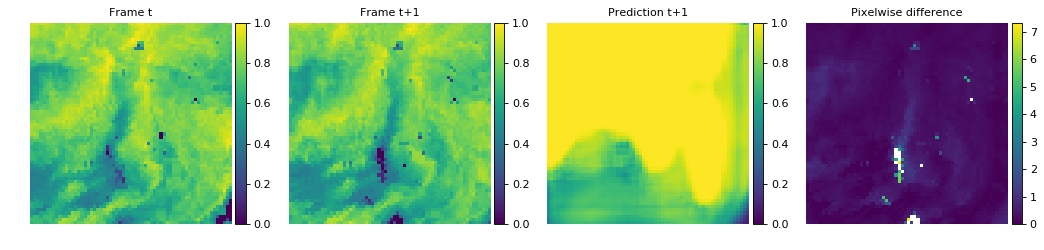

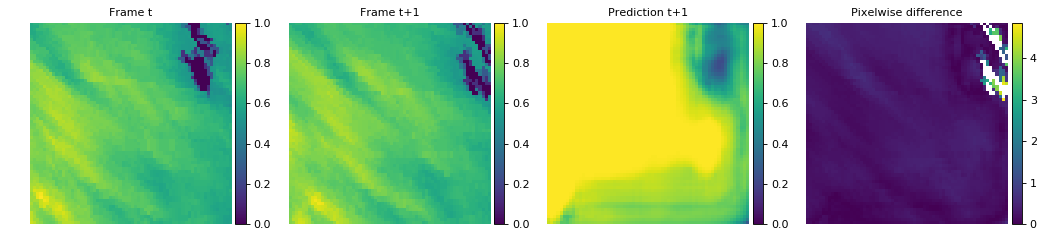

In [21]:
src.result_plotter(args[10:30], (gan_test[:,:,:,0], truth[:,:,:,0], predictions[:,:,:,0], error_images[:,:,:,0]))